In [ ]:
from google.colab import files
files.upload()

Saving GrammarandProductReviews.csv to GrammarandProductReviews.csv


In [ ]:
# Import the generic libraries
import pandas as pd
import numpy as np
from collections import defaultdict
from collections import Counter
import csv

# Import nltk libraries
import nltk
nltk.download('all')
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
lemmatizer = nltk.stem.WordNetLemmatizer()
wordnet_lemmatizer = WordNetLemmatizer()

# Visualization libraries
import plotly.graph_objects as go
import seaborn as sn
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image # for word cloud image

# Spacy for preprocessing
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en_core_web_sm')

# spell checker
!pip install pyspellchecker
from spellchecker import SpellChecker

# Modelling
from sklearn.model_selection import KFold,cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics.pairwise import cosine_similarity

# xgboost
import xgboost as xgb

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.optimizers import Adam

# to change date to datetime
from datetime import datetime
import time
import re

# Textblob
from textblob import TextBlob

# Gensim Libraries
!pip install pyLDAvis
from gensim import corpora, models, similarities, matutils
from gensim.models.ldamulticore import LdaMulticore
import pyLDAvis.gensim_models
from gensim.models import CoherenceModel

# to show all columns
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth',300)

# to pickle dataframe
import pickle

# Avoid warnings
import warnings
warnings.filterwarnings('ignore')

# Enable logging for gensim- optional but important
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

from IPython.display import clear_output
clear_output()



In [ ]:
df = pd.read_csv('/content/GrammarandProductReviews.csv')

In [ ]:
print(df.head())

                     id            brand  \
0  AV13O1A8GV-KLJ3akUyj  Universal Music   
1  AV14LG0R-jtxr-f38QfS         Lundberg   
2  AV14LG0R-jtxr-f38QfS         Lundberg   
3  AV16khLE-jtxr-f38VFn              K-Y   
4  AV16khLE-jtxr-f38VFn              K-Y   

                                                                                                                                                       categories  \
0  Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap   
1                                                                                    Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes   
2                                                                                    Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes   
3                                                                          

In [ ]:
df.columns

Index(['id', 'brand', 'categories', 'dateAdded', 'dateUpdated', 'ean', 'keys',
       'manufacturer', 'manufacturerNumber', 'name', 'reviews.date',
       'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase',
       'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful',
       'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'upc'],
      dtype='object')

## Text Pre-Processing

In [ ]:
print("Shape: ",df.shape)

Shape:  (71044, 25)


In [ ]:
print("Columns: ")
print(df.columns)

Columns: 
Index(['id', 'brand', 'categories', 'dateAdded', 'dateUpdated', 'ean', 'keys',
       'manufacturer', 'manufacturerNumber', 'name', 'reviews.date',
       'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase',
       'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful',
       'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'upc'],
      dtype='object')


We see that the column names are containing two words joined by '.'. So, we will replace the '.' with '_'.

In [ ]:
# rename the columns
col_names = df.columns
new_col_names = [col_name.replace('.','_') for col_name in col_names]
df.columns = new_col_names

In [ ]:
print("Columns: ")
print(df.columns)

Columns: 
Index(['id', 'brand', 'categories', 'dateAdded', 'dateUpdated', 'ean', 'keys',
       'manufacturer', 'manufacturerNumber', 'name', 'reviews_date',
       'reviews_dateAdded', 'reviews_dateSeen', 'reviews_didPurchase',
       'reviews_doRecommend', 'reviews_id', 'reviews_numHelpful',
       'reviews_rating', 'reviews_sourceURLs', 'reviews_text', 'reviews_title',
       'reviews_userCity', 'reviews_userProvince', 'reviews_username', 'upc'],
      dtype='object')


In [ ]:
print("Datatypes: ")
print(df.dtypes)

Datatypes: 
id                       object
brand                    object
categories               object
dateAdded                object
dateUpdated              object
ean                      object
keys                     object
manufacturer             object
manufacturerNumber       object
name                     object
reviews_date             object
reviews_dateAdded        object
reviews_dateSeen         object
reviews_didPurchase      object
reviews_doRecommend      object
reviews_id              float64
reviews_numHelpful      float64
reviews_rating            int64
reviews_sourceURLs       object
reviews_text             object
reviews_title            object
reviews_userCity         object
reviews_userProvince     object
reviews_username         object
upc                      object
dtype: object


In [ ]:
print("Dataset info: ")
print(df.info())

Dataset info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71044 entries, 0 to 71043
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    71044 non-null  object 
 1   brand                 71044 non-null  object 
 2   categories            71044 non-null  object 
 3   dateAdded             71044 non-null  object 
 4   dateUpdated           71044 non-null  object 
 5   ean                   39065 non-null  object 
 6   keys                  71044 non-null  object 
 7   manufacturer          70903 non-null  object 
 8   manufacturerNumber    70841 non-null  object 
 9   name                  71044 non-null  object 
 10  reviews_date          70977 non-null  object 
 11  reviews_dateAdded     71044 non-null  object 
 12  reviews_dateSeen      71044 non-null  object 
 13  reviews_didPurchase   32158 non-null  object 
 14  reviews_doRecommend   60429 non-null  object 
 15  revi

We observe many columns with missing data

In [ ]:
# get missing value counts
print("Missing values: ")
print(df.isnull().sum())

Missing values: 
id                          0
brand                       0
categories                  0
dateAdded                   0
dateUpdated                 0
ean                     31979
keys                        0
manufacturer              141
manufacturerNumber        203
name                        0
reviews_date               67
reviews_dateAdded           0
reviews_dateSeen            0
reviews_didPurchase     38886
reviews_doRecommend     10615
reviews_id              38886
reviews_numHelpful      38536
reviews_rating              0
reviews_sourceURLs          0
reviews_text               36
reviews_title             476
reviews_userCity        65634
reviews_userProvince    70595
reviews_username           96
upc                         2
dtype: int64


We see lot of missing values. We will check the percentage of missing values.

In [ ]:
# get percentage of missing values
print("Missing value percentages: ")
print(df.isnull().mean().round(4) * 100)

Missing value percentages: 
id                       0.00
brand                    0.00
categories               0.00
dateAdded                0.00
dateUpdated              0.00
ean                     45.01
keys                     0.00
manufacturer             0.20
manufacturerNumber       0.29
name                     0.00
reviews_date             0.09
reviews_dateAdded        0.00
reviews_dateSeen         0.00
reviews_didPurchase     54.74
reviews_doRecommend     14.94
reviews_id              54.74
reviews_numHelpful      54.24
reviews_rating           0.00
reviews_sourceURLs       0.00
reviews_text             0.05
reviews_title            0.67
reviews_userCity        92.39
reviews_userProvince    99.37
reviews_username         0.14
upc                      0.00
dtype: float64


We will keep an eye on the columns with more than 70-80% missing data.

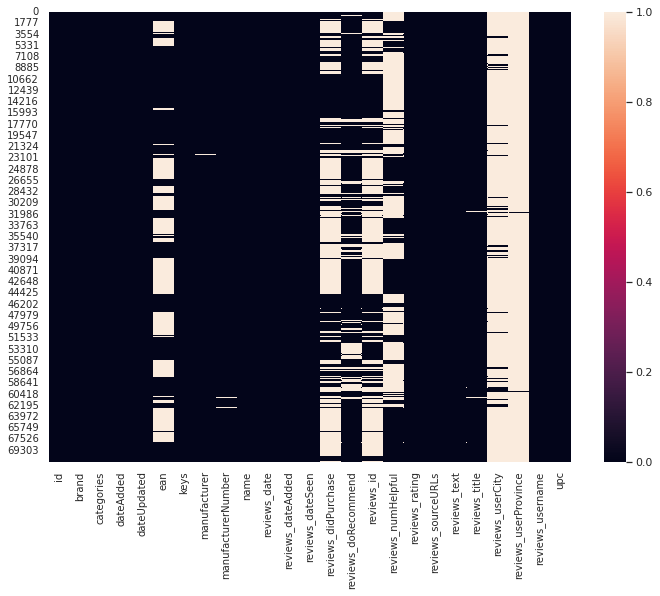

In [ ]:
# Visualization of missing values
sn.set(rc={'figure.figsize':(11.7,8.27)})
sn.heatmap(data = df.isnull())
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

Drop the columns with less than 20% of the values


In [ ]:
missing_val_threshold = len(df) * .2
df.dropna(thresh = missing_val_threshold, axis=1, inplace=True)

In [ ]:
print("Columns: ")
print(df.columns)

Columns: 
Index(['id', 'brand', 'categories', 'dateAdded', 'dateUpdated', 'ean', 'keys',
       'manufacturer', 'manufacturerNumber', 'name', 'reviews_date',
       'reviews_dateAdded', 'reviews_dateSeen', 'reviews_didPurchase',
       'reviews_doRecommend', 'reviews_id', 'reviews_numHelpful',
       'reviews_rating', 'reviews_sourceURLs', 'reviews_text', 'reviews_title',
       'reviews_username', 'upc'],
      dtype='object')


We see that 'usercity' and 'userprovince' columns have been removed.

In [ ]:
print("New shape: ")
print(df.shape)

New shape: 
(71044, 23)


We observe that we have not lost any data even after dropping the two columns.

As reviews_text and reviews_date columns are of more importance to us, we will check for the null values and drop them.

In [ ]:
# drop the rows where "reviews.text" and "reviews.date" has null values
df.dropna(subset=['reviews_text','reviews_date'],inplace=True)

In [ ]:
print("New shape: ")
print(df.shape)

New shape: 
(70941, 23)


We observe that we did not lose more data.

Let's check again the percentage of missing data in each column.

In [ ]:
# get percentage of missing values
print("Missing value percentages: ")
print(df.isnull().mean().round(4) * 100)

Missing value percentages: 
id                      0.00
brand                   0.00
categories              0.00
dateAdded               0.00
dateUpdated             0.00
ean                    45.07
keys                    0.00
manufacturer            0.20
manufacturerNumber      0.28
name                    0.00
reviews_date            0.00
reviews_dateAdded       0.00
reviews_dateSeen        0.00
reviews_didPurchase    54.67
reviews_doRecommend    14.82
reviews_id             54.67
reviews_numHelpful     54.18
reviews_rating          0.00
reviews_sourceURLs      0.00
reviews_text            0.00
reviews_title           0.65
reviews_username        0.13
upc                     0.00
dtype: float64


Now, we see that we do not have columns with large data missing.

Now, by simple observation we can see that review_title and review_text can be combined together for more useful information.

In [ ]:
# joining review_text and review_title
df['Review'] = df['reviews_title'].map(str) + ' ' + df['reviews_text']

In [ ]:
# Lowercasing the reviews and title column
df['Review'] = df['Review'].apply(lambda x : x.lower())

In [ ]:
df['Review'][0]

"just awesome i love this album. it's very good. more to the hip hop side than her current pop sound.. so hype! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy."

In [ ]:
# remove punctuations
df['Review'] = df['Review'].str.replace('[^\w\s]','')

In [ ]:
df['Review'][0]

'just awesome i love this album its very good more to the hip hop side than her current pop sound so hype i listen to this everyday at the gym i give it 5star rating all the way her metaphors are just crazy'

In [ ]:
# remove stopwords
stop = stopwords.words('english')
df['Review'] = df['Review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
df['Review'][0]

'awesome love album good hip hop side current pop sound hype listen everyday gym give 5star rating way metaphors crazy'

### Lemmatization

In [ ]:
def nltk_tag_to_wordnet_tag(nltk_tag):
  if nltk_tag.startswith('J'):
    return wordnet.ADJ
  elif nltk_tag.startswith('V'):
    return wordnet.VERB
  elif nltk_tag.startswith('N'):
    return wordnet.NOUN
  elif nltk_tag.startswith('R'):
    return wordnet.ADV
  else:
    return None

In [ ]:
def lemmatize_sentence(sentence):
  # toeknize the sentence and find POS tag for each token
  nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
  # tuple of (token, wordnet_tag)
  wordnet_tagged = map(lambda x : (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
  lemmatized_sentence = []
  for word, tag in wordnet_tagged:
    if tag is None:
      # if there is no tag, append the token as it is
      lemmatized_sentence.append(word)
    else:
      # else use the tag to lemmatize the token
      lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
  return " ".join(lemmatized_sentence)

In [ ]:
df['Review'] = df['Review'].apply(lambda x : lemmatize_sentence(x))

In [ ]:
df['Review'][0]

'awesome love album good hip hop side current pop sound hype listen everyday gym give 5star rating way metaphor crazy'

### Spelling correction

In [ ]:
spell = SpellChecker()

df['Review'] = df['Review'].apply(lambda x : ' '.join(spell.correction(word) for word in nltk.word_tokenize(x)))

In [ ]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/Updated_GrammarAndProductReviews.csv')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Updated_GrammarAndProductReviews.csv')

In [ ]:
print(df['Review'][0])

awesome love album good hip hop side current pop sound hype listen everyday gym give star rating way metaphor crazy


### Noise removal

In [ ]:
def scrub_words(text):
  """Basic cleaning of texts"""

  # remove html markup
  text = re.sub("(<.*?>)",'',text)

  # remove non-ascii and digits
  text = re.sub("(\\W|\\d)",' ',text)

  # remove whitespace
  text = text.strip()

  return text

In [ ]:
df['Review'] = df['Review'].apply(lambda x : scrub_words(x))

In [ ]:
df['Review'][0]

'awesome love album good hip hop side current pop sound hype listen everyday gym give star rating way metaphor crazy'

### Word Count

In [ ]:
df['Review_WC'] = df['Review'].apply(lambda x : len(str(x).split(' ')))
print(df[['Review','Review_WC']].head(3))

                                                                                                                Review  \
0  awesome love album good hip hop side current pop sound hype listen everyday gym give star rating way metaphor crazy   
1                                                                       good good flavor review collect part promotion   
2                                                                                                     good good flavor   

   Review_WC  
0         20  
1          7  
2          3  


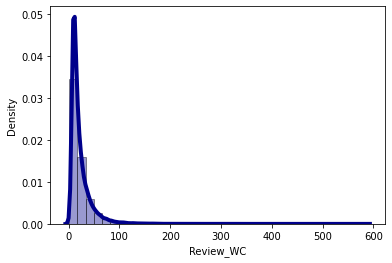

In [ ]:
# Dense Plot and Histogram of all word count
sn.distplot(df['Review_WC'], hist=True, kde=True,
            bins=int(180/5), color='darkblue',
            hist_kws={'edgecolor':'black'},
            kde_kws={'linewidth':4})

We see that most of the reviews are having word count around 10-100. So, we will treat the reviews with more words as outliers.

### Character count

In [ ]:
df['Review_CC'] = df['Review'].str.len()
print(df[['Review','Review_CC']].head(3))

                                                                                                                Review  \
0  awesome love album good hip hop side current pop sound hype listen everyday gym give star rating way metaphor crazy   
1                                                                       good good flavor review collect part promotion   
2                                                                                                     good good flavor   

   Review_CC  
0        115  
1         46  
2         16  


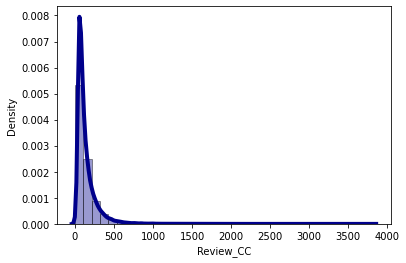

In [ ]:
# Dense Plot and Histogram of all word count
sn.distplot(df['Review_CC'], hist=True, kde=True,
            bins=int(180/5), color='darkblue',
            hist_kws={'edgecolor':'black'},
            kde_kws={'linewidth':4})

We see that most of the reviews are having characters 100-300.

Average Word Length

In [ ]:
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

df['Review_AWL'] = df['Review'].apply(lambda x : avg_word(x))
df[['Review_AWL','Review']].head(3)

,Review_AWL,Review
0,4.800000,awesome love album good hip hop side current pop sound hype listen everyday gym give star rating way metaphor crazy
1,5.714286,good good flavor review collect part promotion
2,4.666667,good good flavor


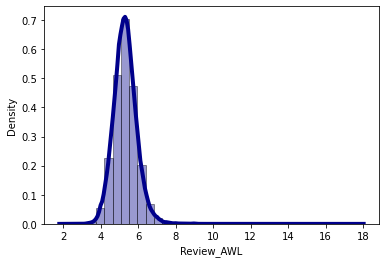

In [ ]:
# Dense Plot and Histogram of all word count
sn.distplot(df['Review_AWL'], hist=True, kde=True,
            bins=int(180/5), color='darkblue',
            hist_kws={'edgecolor':'black'},
            kde_kws={'linewidth':4})

### Top 30 Common words

To get understanding of what our dataset actually contains, we will take a look at top 30 words from the dataset

In [ ]:
# function to plot more frequent terms
def freq_words( x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns='count', n= terms)
  plt.figure(figsize=(20,10))
  ax = sn.barplot(data=d, x='count', y='word')
  ax.set(ylabel='word')
  plt.show()

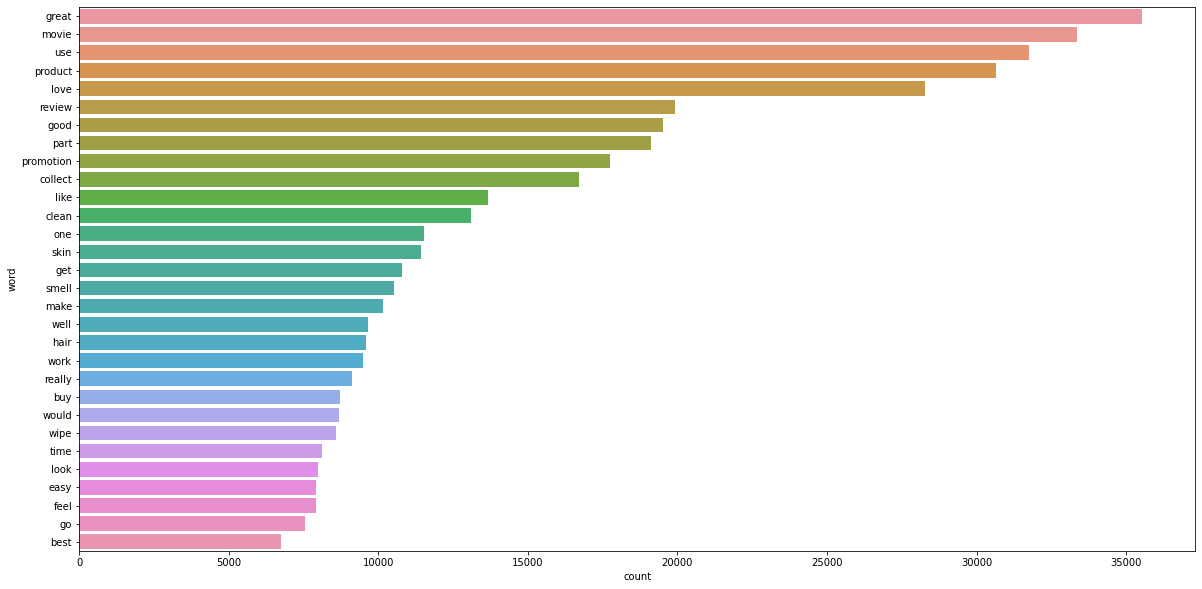

In [ ]:
freq_words(df['Review'])

'great' is the most common word which means we have positive reviews in our dataset.

### Top 30 rare words

We will try to find the most rare words. There will be two cases for rare words- either it is a very exclusive linguistic word rarely used in daily vocabulary or it is a spelling mistake.

In [ ]:
# function to plot least frequent terms
def freq_words( x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nsmallest(columns='count', n= terms)
  plt.figure(figsize=(20,10))
  ax = sn.barplot(data=d, x='count', y='word')
  ax.set(ylabel='word')
  plt.show()

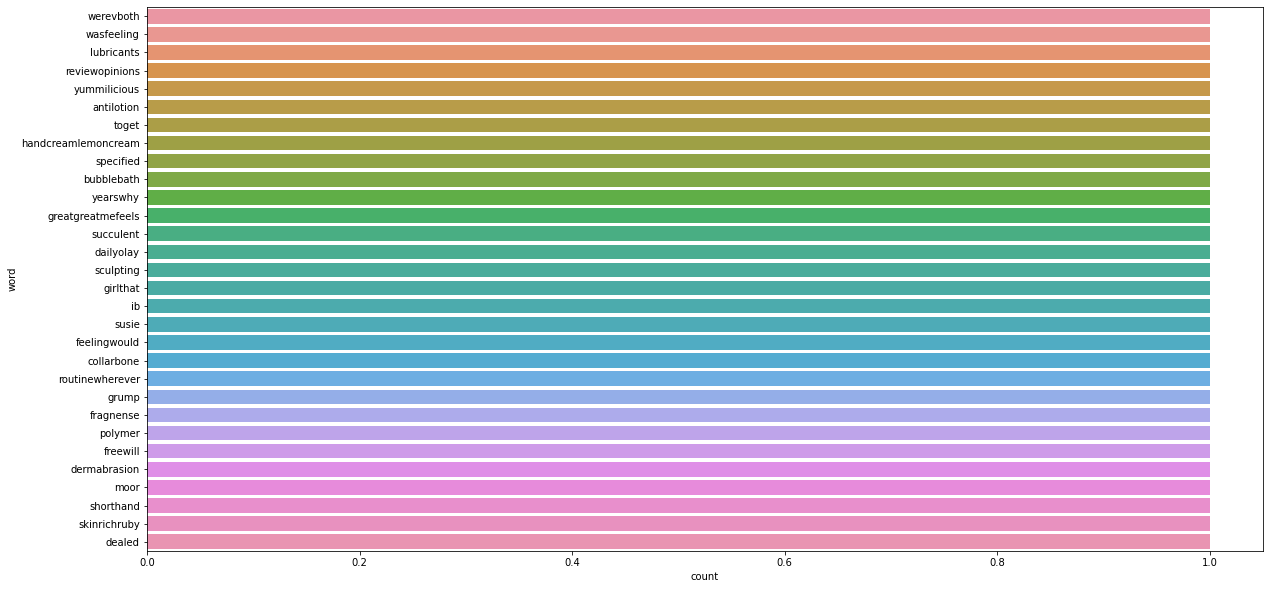

In [ ]:
freq_words(df['Review'])

### Feature Extraction

Let's convert text into numeric format

Term Frequency TF

In [ ]:
df_tf = (df['Review'][0:1]).apply(lambda x : pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
df_tf.columns = ['words','tf']
df_tf

,words,tf
0,awesome,1
1,love,1
2,metaphor,1
3,way,1
4,rating,1
5,star,1
6,give,1
7,gym,1
8,everyday,1
9,listen,1


Inverse Document Frequency IDF

In [ ]:
for i,word in enumerate(df_tf['words']):
  df_tf.loc[i, 'idf'] = np.log(df_tf.shape[0]/(len(df[df['Review'].str.contains(word)])))

In [ ]:
df_tf

,words,tf,idf
0,awesome,1,-5.169347
1,love,1,-7.029043
2,metaphor,1,1.897120
3,way,1,-5.978126
4,rating,1,-2.411439
5,star,1,-5.061012
6,give,1,-4.946630
7,gym,1,-1.398717
8,everyday,1,-3.732896
9,listen,1,-2.541602


TF-IDF

In [ ]:
df_tf['tfidf'] = df_tf['tf'] * df_tf['idf']
df_tf

,words,tf,idf,tfidf
0,awesome,1,-5.169347,-5.169347
1,love,1,-7.029043,-7.029043
2,metaphor,1,1.897120,1.897120
3,way,1,-5.978126,-5.978126
4,rating,1,-2.411439,-2.411439
5,star,1,-5.061012,-5.061012
6,give,1,-4.946630,-4.946630
7,gym,1,-1.398717,-1.398717
8,everyday,1,-3.732896,-3.732896
9,listen,1,-2.541602,-2.541602


Transforming Reviews Date to Python datetime format

In [ ]:
df['reviews_date'].head(10)

0    2012-11-30T06:21:45.000Z
1    2017-07-09T00:00:00.000Z
2    2017-07-09T00:00:00.000Z
3    2016-01-06T00:00:00.000Z
4    2016-12-21T00:00:00.000Z
5    2016-04-20T00:00:00.000Z
6    2016-02-08T00:00:00.000Z
7    2016-02-21T00:00:00.000Z
8    2016-03-28T00:00:00.000Z
9    2016-03-21T00:00:00.000Z
Name: reviews_date, dtype: object

In [ ]:
# replace the 'Z' from date (check the values)
df['reviews_date'] = df['reviews_date'].str.replace(".000Z","")
df['reviews_date'] = df['reviews_date'].str.replace("Z","")

In [ ]:
date = []
for i,j in enumerate(df['reviews_date']):
  try:
    date.append(datetime.strptime(j,"%Y-%m-%dT%H:%M:%S"))
  except:
    print(i)
    j = df['reviews_date'][0]
    date.append(datetime.strptime(j,"%Y-%m-%dT%H:%M:%S"))

df['reviews_date'] = date

28687
28688
28689
28690
28691
28692
28693
28694


We have extracted the features by converting text to numeric using tf-idf and also we have converted the datetime

## Exploratory Data Analysis

We will perform EDA to see the dependency of columns with each other

In [ ]:
col_list = df.columns
col_list

Index(['Unnamed: 0', 'id', 'brand', 'categories', 'dateAdded', 'dateUpdated',
       'ean', 'keys', 'manufacturer', 'manufacturerNumber', 'name',
       'reviews_date', 'reviews_dateAdded', 'reviews_dateSeen',
       'reviews_didPurchase', 'reviews_doRecommend', 'reviews_id',
       'reviews_numHelpful', 'reviews_rating', 'reviews_sourceURLs',
       'reviews_text', 'reviews_title', 'reviews_username', 'upc', 'Review',
       'Review_WC', 'Review_CC', 'Review_AWL'],
      dtype='object')

### Unique values

Let's check unique values from certain columns

In [ ]:
for i in ['brand','categories','manufacturer','name','reviews_id','reviews_rating']:
  print("No. of unique values in %s is : %s"%(i, df[i].nunique()))

No. of unique values in brand is : 387
No. of unique values in categories is : 575
No. of unique values in manufacturer is : 458
No. of unique values in name is : 594
No. of unique values in reviews_id is : 31372
No. of unique values in reviews_rating is : 5


Let's now perform EDA on each column from above one by one

### Distribution of top 25 reviewed brands

We have a lot of brands reviewed, so for convenience we will select top 25 most reviewed brands.

In [ ]:
sorted(df['brand'].unique())

['4C Foods',
 'AMBI',
 'ANCHOR BAY',
 'Adesso',
 'Advantage',
 "Africa's Best",
 'Air Wick',
 'Alberto VO5',
 'Alera',
 'All-Bran',
 'Almay',
 'American Atelier',
 'American Crew',
 'American Greetings',
 "Amy's",
 "Annie's",
 'Anti Monkey Butt',
 'Arrid',
 'Attitude',
 'Attwood',
 'Aussie',
 'Australian Gold',
 'Aveeno',
 'Avery',
 'Axe',
 'BETTER BUILT',
 'Baby Banana',
 'Baby Jogger',
 'Badger',
 'Banana Boat',
 'Barielle',
 'Batherapy',
 'Baxter of California',
 'Baxton Studio',
 'Beanitos',
 'Bebe Au Lait',
 'Bedtime Originals',
 "Ben & Jerry's",
 'Benadryl',
 'Bengay',
 'Bestway',
 'Biokleen',
 'Biore',
 'Biotene',
 'Bisquick',
 'Black Opal',
 'Black Radiance',
 'Body Fantasies',
 'Bodycology',
 'Bosch',
 'Bounce',
 'Brownline',
 'Bumble Bee',
 "Burt's Bees",
 'CHI',
 'COOLA',
 'CRITERION COLLECTION INC',
 'Cal Lighting',
 'Caldrea',
 'Calvin Klein',
 'Canada Dry',
 'Cantu',
 'Care Free Curl',
 'Caress',
 'Caribou Coffee',
 'Carson-Dellosa Publishing',
 'CeraVe',
 'Cerave',
 'Cet

We observe irregularity with the brand names -  "L'oreal Paris" and "L'Oreal Paris". Also, "Sony" and "Sony Pictures" can be thought of as same company. 

So, we will take care of these two irregularities.

In [ ]:
df['brand'] = df['brand'].replace("L'oreal Paris","L'Oreal Paris")
df['brand'] = df['brand'].replace("Sony","Sony Pictures")

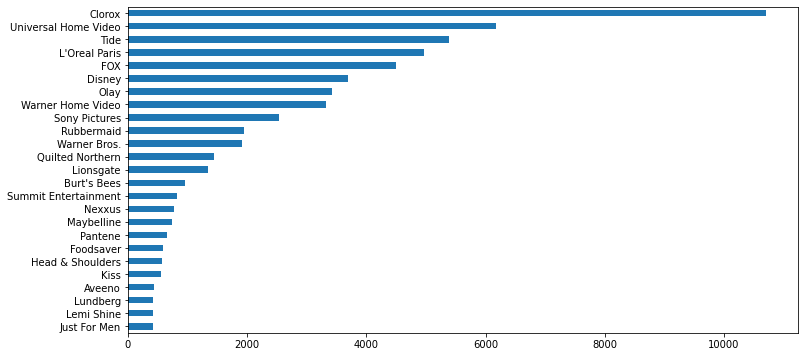

In [ ]:
plt.figure(figsize=(12,6))
df['brand'].value_counts()[0:25].sort_values().plot(kind='barh')
plt.show()

In [ ]:
col_list

Index(['Unnamed: 0', 'id', 'brand', 'categories', 'dateAdded', 'dateUpdated',
       'ean', 'keys', 'manufacturer', 'manufacturerNumber', 'name',
       'reviews_date', 'reviews_dateAdded', 'reviews_dateSeen',
       'reviews_didPurchase', 'reviews_doRecommend', 'reviews_id',
       'reviews_numHelpful', 'reviews_rating', 'reviews_sourceURLs',
       'reviews_text', 'reviews_title', 'reviews_username', 'upc', 'Review',
       'Review_WC', 'Review_CC', 'Review_AWL'],
      dtype='object')

### Distribution of categories

In [ ]:
sorted(df['categories'].unique())

['Accessories,Jewelry,Jewelry Cleaning,Polishing & Buffing,Jewelry Cleaners,Household Cleaners,Cleaning',
 'Auto & Tires,Automotive Interior,Car Organizers,Interior Car Accessories,Cargo Mat,Interior Accessories',
 'Auto & Tires,Automotive Interior,Car Organizers,Interior Car Accessories,Tool Chests,Tool Boxes - Truck Bed,Tools',
 'Auto & Tires,Motorcycle and ATV,Motorcycle,Motorcycle Parts,Motorcycle Tires,Cruiser,Tire Tubes',
 'Auto & Tires,Motorcycle and ATV,Motorcycle,Motorcycle Parts,Motorcycle Tires,Cruiser,Tires,Tire Tubes',
 'Baby,Nursery & Decor,Furniture,Rocking Chairs,Gliders & Rockers,Baby Gear,Nursery Furniture,Gliders,Stork Craft,Rockers, Gliders,Kitchen & Dining Features,Living Room Furniture,Living Room Chairs,Home & Kitchen Features,Nursery Seating',
 'Baby,Nursery,Baby Bedding,Crib Sheets,Nursery & Decor,Bedding,Sheets,Toddler,Toddler Bedding Sets & Sheets,Bedding Sets',
 'Baby,Nursery,Baby Decor,Mobiles,Nursery & Decor,Decor,Decoration,Baby Products,Nursery Decor',
 

We observe that most of the categories are almost same but have very little differences, so we will try to replace similar categories into one group.

In [ ]:
df['product_cat'] = df['categories'].apply(lambda x : x.split(',')[0])
print(sorted(df['product_cat'].unique()))

['Accessories', 'Auto & Tires', 'Baby', 'Beauty', 'Brand Shop', 'Clothing', 'Electronics', 'Featured Brands', 'Food', 'Food & Beverage', 'Furniture', 'Gift Finder', 'Health', 'Holiday Shop', 'Home', 'Home Improvement', 'Household Chemicals', 'Household Essentials', "Kids' Rooms", 'Kitchen & Dining', 'Mobile', 'Movies', 'Movies & TV Shows', 'Music on CD or Vinyl', 'Musical Instruments & Karaoke', 'Office', 'Party & Occasions', 'Party Supplies', 'Patio & Garden', 'Personal Care', 'Pets', 'Photography', 'Pro Audio', 'School & Office Supplies', 'Sports & Outdoors', 'Video Games']


In [ ]:
len(df['product_cat'].unique())

36

In [ ]:
df['product_cat'] = df['product_cat'].replace("Movies","Movies & TV Shows")
df['product_cat'] = df['product_cat'].replace('Food','Food & Beverage')
df['product_cat'] = df['product_cat'].replace('Household Chemicals','Household Essentials')
df['product_cat'] = df['product_cat'].replace("Music on CD or Vinyl","Musical Instruments & Karaoke")
df['product_cat'] = df['product_cat'].replace("Pro Audio","Musical Instruments & Karaoke")
df['product_cat'] = df['product_cat'].replace("Baby","Kids")
df['product_cat'] = df['product_cat'].replace("Kids' Rooms","Kids")
df['product_cat'] = df['product_cat'].replace("Brand Shop","Household Essentials")
df['product_cat'] = df['product_cat'].replace("Featured Brands","Household Essentials")
df['product_cat'] = df['product_cat'].replace("Home Improvement","Household Essentials")
df['product_cat'] = df['product_cat'].replace("Furniture","Household Essentials")
df['product_cat'] = df['product_cat'].replace("Video Games","Sports & Outdoors")
df['product_cat'] = df['product_cat'].replace("Home","Household Essentials")
df['product_cat'] = df['product_cat'].replace("Mobile","Electronics")
df['product_cat'] = df['product_cat'].replace("Photography","Electronics")
df['product_cat'] = df['product_cat'].replace("Patio & Garden","Accessories")
df['product_cat'] = df['product_cat'].replace("Gift Finder","Accessories")
df['product_cat'] = df['product_cat'].replace("Auto & Tires","Accessories")
df['product_cat'] = df['product_cat'].replace("Kitchen & Dining","Food & Beverage")


In [ ]:
len(df['product_cat'].unique())

18

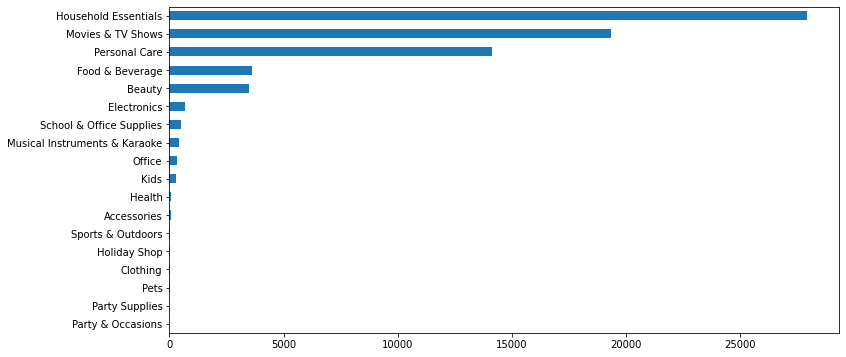

In [ ]:
plt.figure(figsize=(12,6))
df['product_cat'].value_counts()[0:25].sort_values().plot(kind='barh')
plt.show()

In [ ]:
col_list

Index(['Unnamed: 0', 'id', 'brand', 'categories', 'dateAdded', 'dateUpdated',
       'ean', 'keys', 'manufacturer', 'manufacturerNumber', 'name',
       'reviews_date', 'reviews_dateAdded', 'reviews_dateSeen',
       'reviews_didPurchase', 'reviews_doRecommend', 'reviews_id',
       'reviews_numHelpful', 'reviews_rating', 'reviews_sourceURLs',
       'reviews_text', 'reviews_title', 'reviews_username', 'upc', 'Review',
       'Review_WC', 'Review_CC', 'Review_AWL'],
      dtype='object')

### Distribution of manufacturers

In [ ]:
# df['manufacturer'] = df['manufacturer'].replace('120','one twenty')
# df['manufacturer'] = df['manufacturer'].replace('161840:Quilted Northern','Quilted Northern')

In [ ]:
df['manufacturer'] = df['manufacturer'].astype('str')

In [ ]:
print(sorted(df['manufacturer'].unique()))

['120', '1200', '161840:Quilted Northern', '20th Century Fox', 'ABKCO', 'ACCO', 'ACCO BRANDS, INC.', 'ALERA', 'ANTI MONKEY BUTT', 'AUSTRALIAN GOLD PRODUCTS LTD.', 'Adesso Inc.', 'Advanced Beauty', 'Allure Home', 'Almay', 'AmazonUs/CLOO7', 'American Coffee Partnership', 'American Crew', 'American Greetings', 'American Pop Corn Co.', 'American crew', "Amy's Kitchen", 'Anchor Bay Entertainment', "Annie's Homegrown", 'Annies Homegrown', 'Arc Abrasives', 'Arrid', 'Attitude', 'Attwood, Inc.', 'Aussie', 'Aveeno', 'Aveeno Baby', 'Avery', 'Avery Dennison', 'Axe', 'B&G Foods, Inc.', 'BETTER BUILT', 'BNRG', 'Baby Jogger', 'Badger Balm', 'Bareminerals', 'Barielle', 'Baxter of California', 'Beanitos', 'Beautyge Brands USA, Inc.', 'Bebe au Lait', 'Beiersdorf', 'Bengay', 'Bestway (Sports)', 'Biocosmetic Research Labs', 'Biokleen Cleaners', 'Black Radiance', 'Boraam - DROPSHIP', 'Bosch', 'Bounce', 'Broken Bow', 'Buena Vista', 'Bumble Bee', 'Bumble Bee Foods', "Burt's Bees", "Burt's Bees, Inc.", 'CAL L

We observe some of the manufacturers names have been repeated because of spelling dissimilarity. We will fix it.

In [ ]:
df['manufacturer'] = df['manufacturer'].replace("Procter & Gamble Company","Procter & Gamble")
df['manufacturer'] = df['manufacturer'].replace("PROCTER & GAMBLE COMPANY, THE","Procter & Gamble")
df['manufacturer'] = df['manufacturer'].replace("York Wallcoverings Inc","York Wallcoverings")
df['manufacturer'] = df['manufacturer'].replace("Yes To, Inc","Yes To Inc.")
df['manufacturer'] = df['manufacturer'].replace("Walt Disney Records","Walt Disney")
df['manufacturer'] = df['manufacturer'].replace("TIME WARNER","WarnerBrothers")
df['manufacturer'] = df['manufacturer'].replace("TIME WARNER","WarnerBrothers")
df['manufacturer'] = df['manufacturer'].replace("WARNER HOME VIDEO","WarnerBrothers")
df['manufacturer'] = df['manufacturer'].replace("Warner Home Video","WarnerBrothers")
df['manufacturer'] = df['manufacturer'].replace("Universal Studios Home Entertainment","Universal")
df['manufacturer'] = df['manufacturer'].replace("Universal Studios","Universal")
df['manufacturer'] = df['manufacturer'].replace("Universal Music Group / Cash Money","Universal")
df['manufacturer'] = df['manufacturer'].replace("UNIVERSAL HOME ENTERTAINMENT","Universal")
df['manufacturer'] = df['manufacturer'].replace("UNILEVER","Unilever")
df['manufacturer'] = df['manufacturer'].replace("TWENTIETH CENTURY FOX HOME ENT","Twentieth Century Fox")
df['manufacturer'] = df['manufacturer'].replace("Trend Enterprises","Trend Lab")
df['manufacturer'] = df['manufacturer'].replace("Summit Inc/Lionsgate","Summit Entertainment")
df['manufacturer'] = df['manufacturer'].replace("Sony Pictures","Sony")
df['manufacturer'] = df['manufacturer'].replace("Sony Music Nashville","Sony")
df['manufacturer'] = df['manufacturer'].replace("Sony Legacy","Sony")
df['manufacturer'] = df['manufacturer'].replace("SONY CORP","Sony")
df['manufacturer'] = df['manufacturer'].replace("Smead Manufacturing","Smead")
df['manufacturer'] = df['manufacturer'].replace("SC Johnson & Sons","SC JOHNSON")
df['manufacturer'] = df['manufacturer'].replace("S C JOHNSON WAX","SC JOHNSON")
df['manufacturer'] = df['manufacturer'].replace("Rubbermaid Home","Rubbermaid")
df['manufacturer'] = df['manufacturer'].replace("Queen Helene Skin Cream, Lotion","Queen Helene")
df['manufacturer'] = df['manufacturer'].replace("Queen Helene Facial Scrub","Queen Helene")
df['manufacturer'] = df['manufacturer'].replace("Queen Helene Batherapy","Queen Helene")
df['manufacturer'] = df['manufacturer'].replace("Procter & Gamble Company","Procter & Gamble")
df['manufacturer'] = df['manufacturer'].replace("Physicians Mineral Loose Powder","Physicians Formula")
df['manufacturer'] = df['manufacturer'].replace("Pantene Pro-V Hair Care","Pantene")
df['manufacturer'] = df['manufacturer'].replace("Newman's Own, Inc.","Newman's Own")
df['manufacturer'] = df['manufacturer'].replace("Milani Cosmetics","Milani")
df['manufacturer'] = df['manufacturer'].replace("Maybelline-Garnier-Essie, Consumer Products Division of L'Oréal USA S/D, Inc.","Maybelline")
df['manufacturer'] = df['manufacturer'].replace("Maybelline New York","Maybelline")
df['manufacturer'] = df['manufacturer'].replace("Maybelline LLC","Maybelline")
df['manufacturer'] = df['manufacturer'].replace("MGM (Video & DVD)","MGM HOME ENTERTAINMENT")
df['manufacturer'] = df['manufacturer'].replace("Lundberg","Lundberg Family Farms")
df['manufacturer'] = df['manufacturer'].replace("Annie's Homegrown","Annies Homegrown")
df['manufacturer'] = df['manufacturer'].replace("Burt's Bees","Burt's Bees, Inc.")
df['manufacturer'] = df['manufacturer'].replace("Colgate-Palmolive","Colgate-Palmolive Company")
df['manufacturer'] = df['manufacturer'].replace("Conair","Conair Corporation")
df['manufacturer'] = df['manufacturer'].replace("Coty Inc.","Coty brands")
df['manufacturer'] = df['manufacturer'].replace("Disney/Pixar","Disney")
df['manufacturer'] = df['manufacturer'].replace("E&E Co.","E&E Co. Ltd")
df['manufacturer'] = df['manufacturer'].replace("Frito-Lay, Inc.","Frito-Lay")
df['manufacturer'] = df['manufacturer'].replace("General Mills Sales, Inc.","General Mills")
df['manufacturer'] = df['manufacturer'].replace("General Mills, Inc.","General Mills")
df['manufacturer'] = df['manufacturer'].replace("Hormel Foods Corp. Meat Products","Hormel")
df['manufacturer'] = df['manufacturer'].replace("Hormel Foods Corporation","Hormel")
df['manufacturer'] = df['manufacturer'].replace("Johnson & Johnson SLC","Johnson & Johnson")
df['manufacturer'] = df['manufacturer'].replace("Kellogg Sales Co","Kellogg Company")
df['manufacturer'] = df['manufacturer'].replace("Kellogg Sales Co.","Kellogg Company")
df['manufacturer'] = df['manufacturer'].replace("Kind Fruit & Nut Bars","Kind Fruit and Nut Bars")
df['manufacturer'] = df['manufacturer'].replace("L'OREAL SA","L'Oreal Paris")
df['manufacturer'] = df['manufacturer'].replace("L'Oral USA, Inc.","L'Oreal Paris")
df['manufacturer'] = df['manufacturer'].replace("L'Oreal","L'Oreal Paris")
df['manufacturer'] = df['manufacturer'].replace("L'oreal / Cosmair","L'Oreal Paris")
df['manufacturer'] = df['manufacturer'].replace("L'oreal Paris","L'Oreal Paris")
df['manufacturer'] = df['manufacturer'].replace("Lions Gate Home Ent.","Lions Gate")
df['manufacturer'] = df['manufacturer'].replace("Lite Source Inc.","Lite Source")
df['manufacturer'] = df['manufacturer'].replace("Lite-Source","Lite Source")

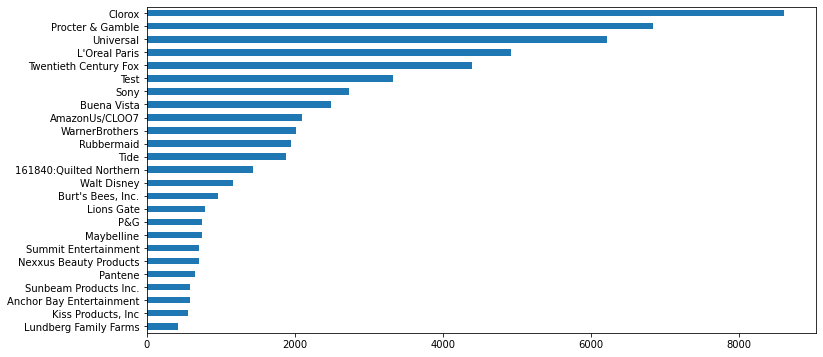

In [ ]:
plt.figure(figsize=(12,6))
df['manufacturer'].value_counts()[0:25].sort_values().plot(kind='barh')
plt.show()

In [ ]:
col_list

Index(['Unnamed: 0', 'id', 'brand', 'categories', 'dateAdded', 'dateUpdated',
       'ean', 'keys', 'manufacturer', 'manufacturerNumber', 'name',
       'reviews_date', 'reviews_dateAdded', 'reviews_dateSeen',
       'reviews_didPurchase', 'reviews_doRecommend', 'reviews_id',
       'reviews_numHelpful', 'reviews_rating', 'reviews_sourceURLs',
       'reviews_text', 'reviews_title', 'reviews_username', 'upc', 'Review',
       'Review_WC', 'Review_CC', 'Review_AWL'],
      dtype='object')

### Distribution of rating

rating is important factor in sentiment analysis,

5 rating - positive sentiment
1 rating - negative sentiment

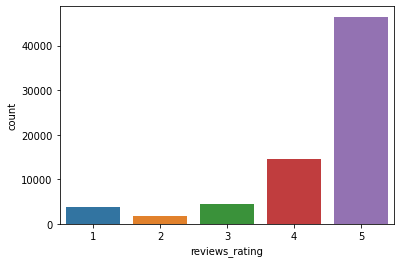

In [ ]:
sn.countplot(df['reviews_rating'])

### Year wise rating

In [ ]:
df['year'], df['day'], df['month'] = df['reviews_date'].dt.year, df['reviews_date'].dt.date, df['reviews_date'].dt.month

df['hour'], df['minutes'], df['seconds'] = df['reviews_date'].dt.hour, df['reviews_date'].dt.minute, df['reviews_date'].dt.second

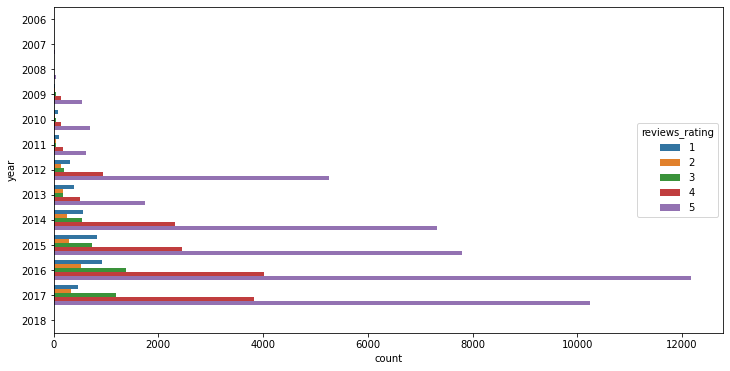

In [ ]:
plt.figure(figsize=(12,6))
sn.countplot(y=df['year'],hue=df['reviews_rating'])

### Hour wise ratings

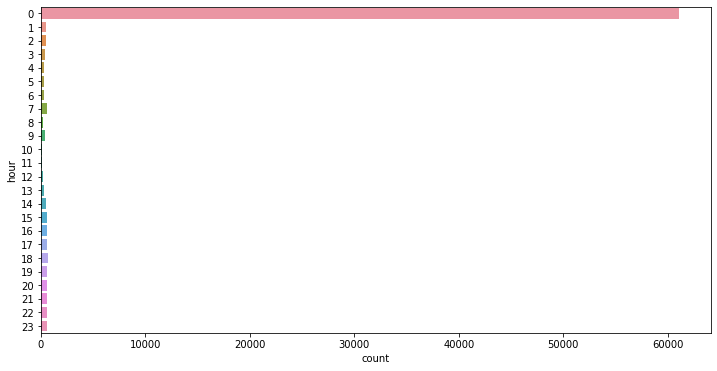

In [ ]:
plt.figure(figsize=(12,6))
sn.countplot(y=df['hour'])

hourwise distribution of ratings does not make much sense, hence we will ignore this factor.

In [ ]:
col_list

Index(['Unnamed: 0', 'id', 'brand', 'categories', 'dateAdded', 'dateUpdated',
       'ean', 'keys', 'manufacturer', 'manufacturerNumber', 'name',
       'reviews_date', 'reviews_dateAdded', 'reviews_dateSeen',
       'reviews_didPurchase', 'reviews_doRecommend', 'reviews_id',
       'reviews_numHelpful', 'reviews_rating', 'reviews_sourceURLs',
       'reviews_text', 'reviews_title', 'reviews_username', 'upc', 'Review',
       'Review_WC', 'Review_CC', 'Review_AWL'],
      dtype='object')

Now, let's start comparing independent variables with dependent variable.

### Category vs Ratings

In [ ]:
df['product_cat'].value_counts()

Household Essentials             27933
Movies & TV Shows                19352
Personal Care                    14112
Food & Beverage                   3599
Beauty                            3478
Electronics                        691
School & Office Supplies           504
Musical Instruments & Karaoke      426
Office                             315
Kids                               298
Health                              86
Accessories                         73
Sports & Outdoors                   31
Holiday Shop                        30
Clothing                             5
Pets                                 4
Party Supplies                       2
Party & Occasions                    2
Name: product_cat, dtype: int64

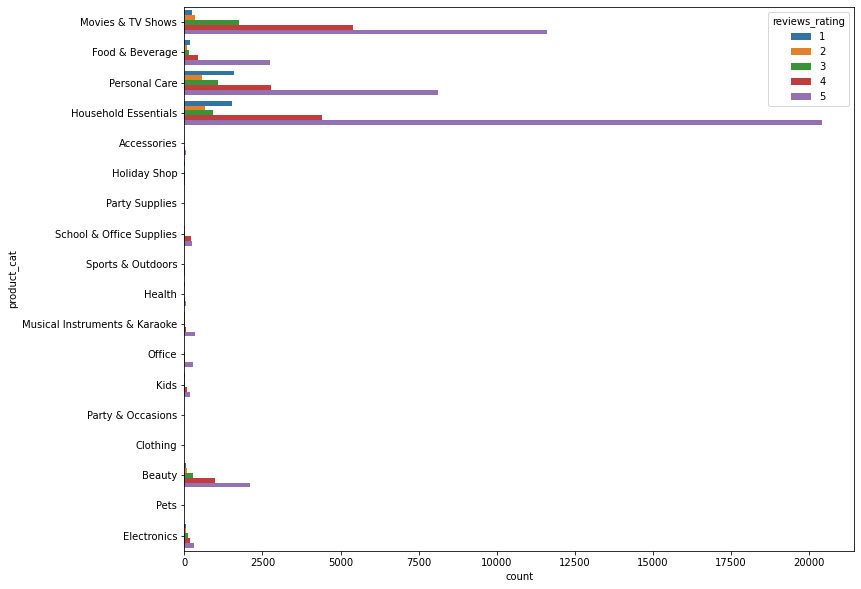

In [ ]:
plt.figure(figsize=(12,10))
sn.countplot(y=df['product_cat'],hue=df['reviews_rating'])
plt.show()

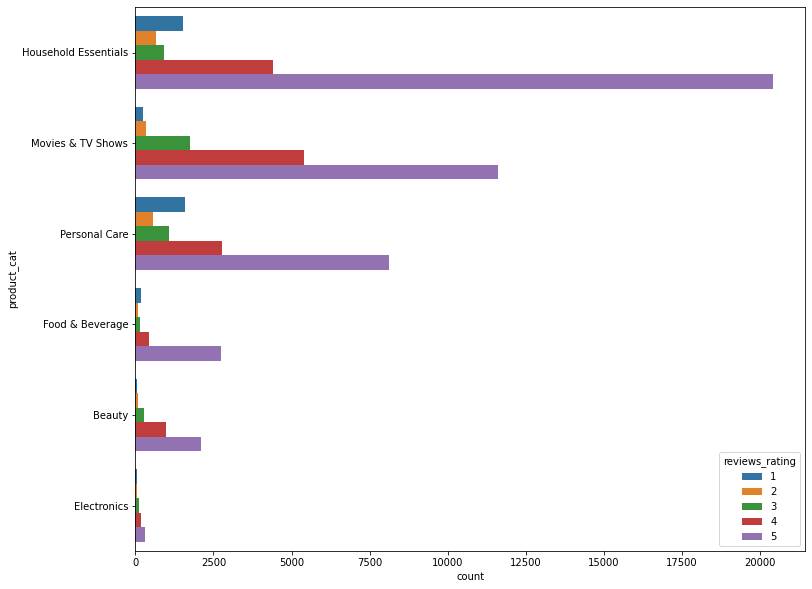

In [ ]:
plt.figure(figsize=(12,10))
sn.countplot(y=df['product_cat'],hue=df['reviews_rating'],order=df['product_cat'].value_counts().iloc[:6].index)
plt.show()

### Brands vs Ratings

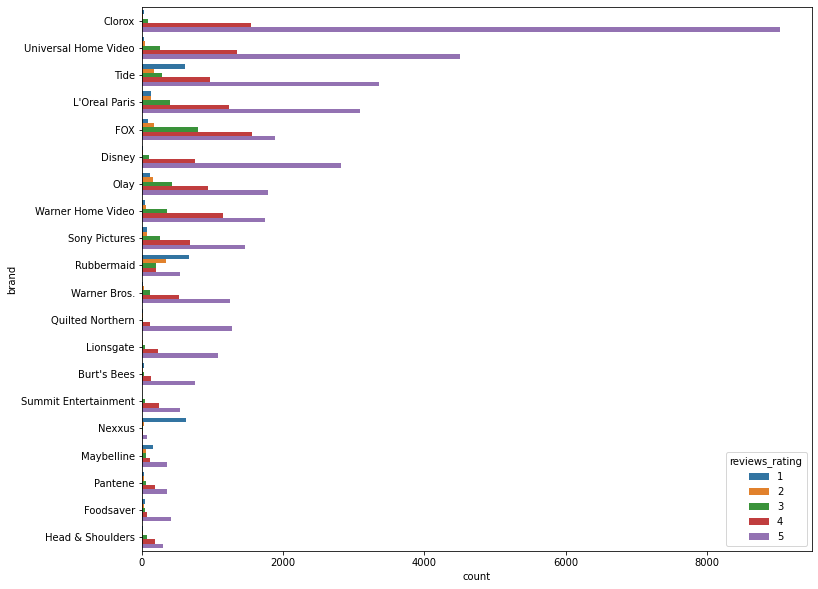

In [ ]:
plt.figure(figsize=(12,10))
sn.countplot(y=df['brand'],hue=df['reviews_rating'],order=df['brand'].value_counts().iloc[:20].index)
plt.show()

### WordCloud

Now, we will use WordCloud to see the pictorial representation of words in reviews.
We have already seen the frequency of words in above steps.

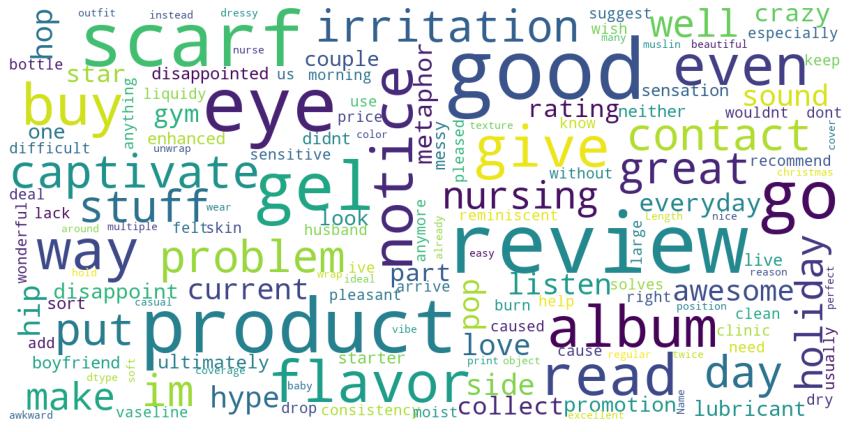

In [ ]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title=None):
  wordcloud = WordCloud(
      background_color='white',
      stopwords=stopwords,
      max_words = 300,
      max_font_size=40,
      scale=3,
      random_state=1  ).generate(str(data))

  fig = plt.figure(1, figsize=(15,15))
  plt.axis('off')
  if title:
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(top=2.3)

  plt.imshow(wordcloud)
  plt.show()

show_wordcloud(df['Review'])

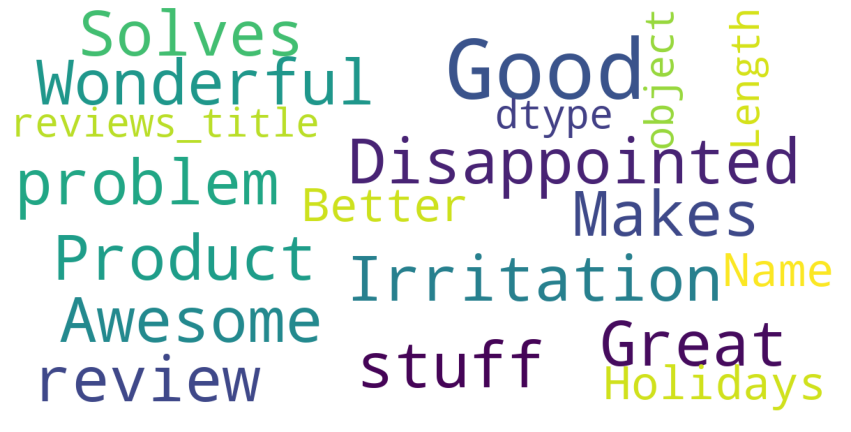

In [ ]:
show_wordcloud(df['reviews_title'])

Wordcloud is juct pictorial representation of unigram from the text. i.e. all the words are plotted in a picture with their size depending on their frequency of occurence.

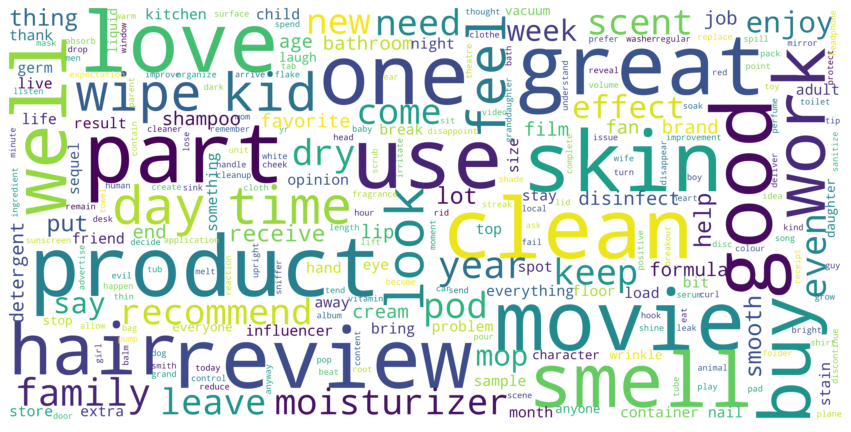

In [ ]:
# try to tokenize to individual words (uni-gram) - reviews.text
split_title = []
listCounts = []
split_title = [x.split(" ") for x in df['Review'].astype(str)]
big_list = []
for x in split_title:
  big_list.extend(x)

listCounts = pd.Series(big_list).value_counts()

wordcloud = WordCloud(background_color='white',max_words=400,max_font_size=40,scale=30,random_state=1).generate((listCounts[listCounts > 2]).to_string())

plt.figure(figsize=(15,15))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
len(big_list)

1613519

Now, let's try to find out genuine reviews.

Genuine review - Review where customer has actually purchased the product and submitted the review.

In [ ]:
df['reviews_didPurchase'].head(3)

0     NaN
1    True
2    True
Name: reviews_didPurchase, dtype: object

In [ ]:
# on the 'reviews_didPurchase' column
df['reviews_didPurchase'].isnull().sum()

38785

In [ ]:
# replace the NaN values with word "null"
df['reviews_didPurchase'].fillna('Null',inplace=True)

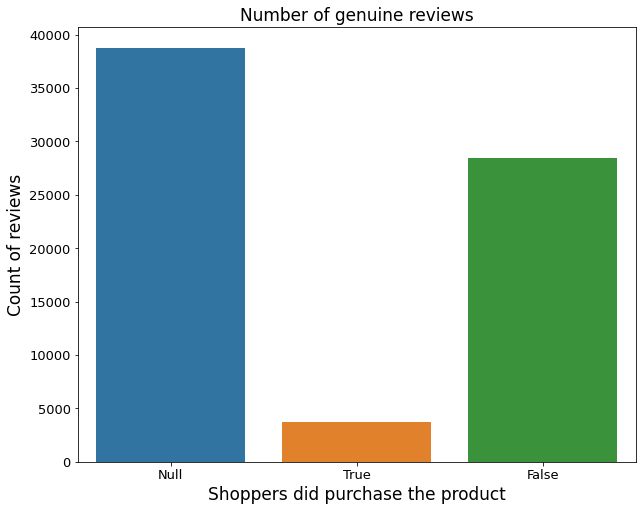

In [ ]:
plt.figure(figsize=(10,8))
ax = sn.countplot(df['reviews_didPurchase'])
ax.set_xlabel(xlabel="Shoppers did purchase the product",fontsize=17)
ax.set_ylabel(ylabel="Count of reviews",fontsize=17)
ax.axes.set_title("Number of genuine reviews",fontsize=17)
ax.tick_params(labelsize=13)

We have very less data where the reviews are from the customers who have actually purchased the product.

In [ ]:
df['reviews_didPurchase'].value_counts()

Null     38785
False    28474
True      3682
Name: reviews_didPurchase, dtype: int64

### Correlation map

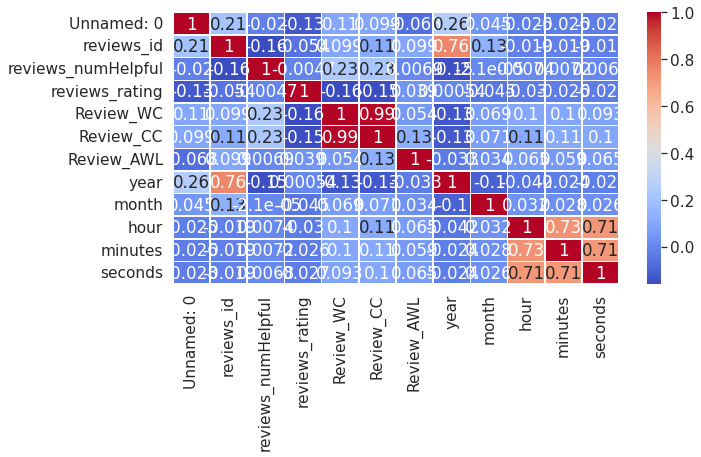

In [ ]:
sn.set(font_scale=1.4)
plt.figure(figsize=(10,5))
sn.heatmap(df.corr(),cmap='coolwarm',annot=True,linewidths=.5)

Not much info can be obtained from correlation heatmap.

Let's create a dataframe with only genuine reviews.

In [ ]:
df_gen = df[df['reviews_didPurchase'] == True]

In [ ]:
df_gen.columns

Index(['Unnamed: 0', 'id', 'brand', 'categories', 'dateAdded', 'dateUpdated',
       'ean', 'keys', 'manufacturer', 'manufacturerNumber', 'name',
       'reviews_date', 'reviews_dateAdded', 'reviews_dateSeen',
       'reviews_didPurchase', 'reviews_doRecommend', 'reviews_id',
       'reviews_numHelpful', 'reviews_rating', 'reviews_sourceURLs',
       'reviews_text', 'reviews_title', 'reviews_username', 'upc', 'Review',
       'Review_WC', 'Review_CC', 'Review_AWL', 'product_cat', 'year', 'day',
       'month', 'hour', 'minutes', 'seconds'],
      dtype='object')

### Most bought product

In [ ]:
df_gen['name'].value_counts()

The Foodsaver174 10 Cup Fresh Container - Fac10-000                      477
Pantene Airspray Hairspray - 7 Oz                                        443
Hormel Chili, No Beans                                                    91
Coty Airspun Face Powder, Translucent Extra Coverage                      88
Just For Men Brush-In Color Gel For Mustache & Beard, Dark Brown M-45     80
                                                                        ... 
Kenroy Home Table Lamp - Teal                                              1
Tai Pei Sweet & Sour Chicken                                               1
Lucy's Sugar Cookies, 5.5oz                                                1
Black Radiance Artisan Color Baked Blush, Warm Berry                       1
If A Man Answers (dvd)                                                     1
Name: name, Length: 304, dtype: int64

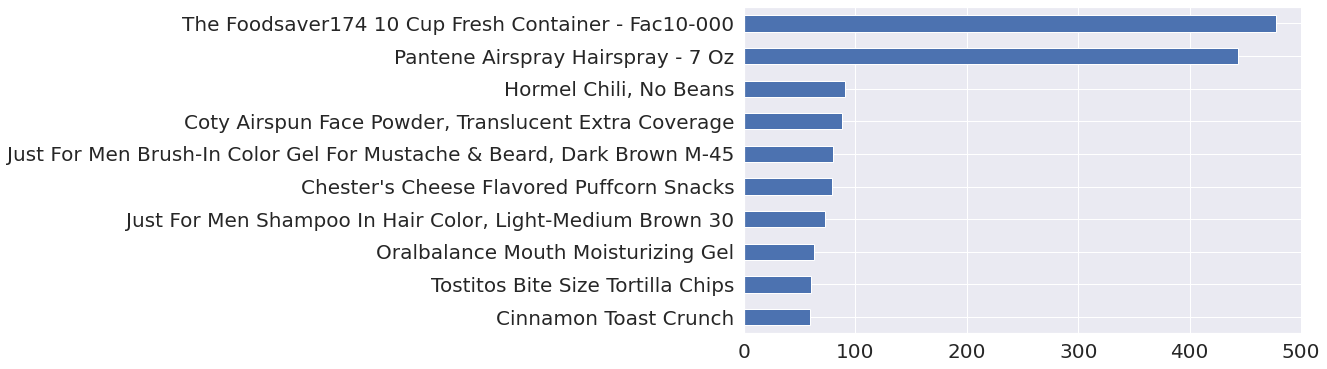

In [ ]:
df_gen['name'].value_counts()[:10].plot(kind='barh',figsize=[10,6],fontsize=20).invert_yaxis()

Now, let's see the 5 rated reviews of most bought product i.e. "The Foodsaver174 10 Cup Fresh Container - Fac10-000"

In [ ]:
#df_mbp - df_most_bought_product
df_mbp = df_gen[df_gen['name'] == 'The Foodsaver174 10 Cup Fresh Container - Fac10-000']
df_mbp = df_mbp[df_mbp['reviews_rating']==5]
# keep relevant columns only
df_mbp = df_mbp[['reviews_rating','Review']]
df_mbp.head()

,reviews_rating,Review
46849,5,clear view content love fact see inside easy fill vacuum stack nicely take less space
46850,5,perfect size use foodsaver container over love add longevity freshness leftover
46851,5,stay seal needed bought set well cup container use fruit lettucethey seal easily stay seal needed big improvement old container
46852,5,solid neat chance use design strength container much well early version container much well design
46853,5,fantastic veggie stay good two week overall well worth


Now, let's see the 1 rated reviews for most bought product

In [ ]:
#df_mbp_1 - df_most_bought_product_1_rated
df_mbp_1 = df_gen[df_gen['name'] == 'The Foodsaver174 10 Cup Fresh Container - Fac10-000']
df_mbp_1 = df_mbp_1[df_mbp_1['reviews_rating']==1]
# keep relevant columns only
df_mbp_1 = df_mbp_1[['reviews_rating','Review']]
df_mbp_1.head()

,reviews_rating,Review
46668,1,unable use think ready use know need buy part make work
46669,1,happy buy month ago try vacuum seal seal stay day need reseal vacuum seal never stay
46671,1,unhappy can not make head tail use product sell part need
46674,1,doesnt stay seal tried numerous time doesnt stay sealed hour
46675,1,keep said fresh like item item say seal


We have finished the EDA.

Now, we will build a ML model and a DL model for sentiment analysis

### Training Data Preperation

Defining features and target variable

In [ ]:
x = df['Review']
y = df['reviews_rating']

Next step is to convert textual data into numeric data.

Here, we will use n-gram tfidf vectorizer

In [ ]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf = True,
    strip_accents = 'unicode',
    analyzer = 'word',
    token_pattern = r'\w{1,}',
    stop_words = 'english',
    ngram_range = (1,3)) # we can manipulate the n-gram range

word_vectorizer.fit(x)
train_word_features = word_vectorizer.transform(x)

In [ ]:
train_word_features

<70941x1234698 sparse matrix of type '<class 'numpy.float64'>'
	with 3597059 stored elements in Compressed Sparse Row format>

In [ ]:
train_word_features.data

array([0.16438347, 0.16438347, 0.05846389, ..., 0.23288446, 0.23288446,
       0.13740868])

In [ ]:
len(train_word_features.data)

3597059

In [ ]:
char_vectorizer = TfidfVectorizer(
    sublinear_tf = True,
    strip_accents = 'unicode',
    analyzer = 'char',
    stop_words = 'english',
    ngram_range = (2,6),
    max_features=50000) # we can manipulate the n-gram range

char_vectorizer.fit(x)
train_char_features = char_vectorizer.transform(x)

In [ ]:
train_char_features

<70941x50000 sparse matrix of type '<class 'numpy.float64'>'
	with 34857618 stored elements in Compressed Sparse Row format>

In [ ]:
len(train_char_features.data)

34857618

Now , we need to combine both word and char features. 

we will use hstack for it. hstack will stack the two things horizontally one after the another.

In [ ]:
train_features = hstack([train_char_features,train_word_features])

In [ ]:
train_features

<70941x1284698 sparse matrix of type '<class 'numpy.float64'>'
	with 38454677 stored elements in COOrdinate format>

In [ ]:
train_features.data

array([0.05755301, 0.05317104, 0.05246791, ..., 0.23288446, 0.23288446,
       0.13740868])

In [ ]:
len(train_features.data)

38454677

We have successfully converted the training textual data into numeric format.

Going forward, we will use this as training data.

### Splitting the training and testing data

In [ ]:
seed = 50 # we can set it to any value

X_train, X_test, Y_train, Y_test = train_test_split(train_features,y,test_size=0.3,random_state=seed)

print("X_train shape: ",X_train.shape)
print("X_test shape: ",X_test.shape)
print("Y_train shape: ",Y_train.shape)
print("Y_test shape: ",Y_test.shape)

X_train shape:  (49658, 1284698)
X_test shape:  (21283, 1284698)
Y_train shape:  (49658,)
Y_test shape:  (21283,)


### ML Model

here, we will try random forest and logistic regression techniques. We can try other ml algorithms also.

### Random Forest classifier

In [ ]:
time_1 = time.time()

classifier = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=seed, n_jobs=-1)

classifier.fit(X_train,Y_train)

preds_1 = classifier.predict(X_test)

time_taken = time.time() - time_1

print("Time taken for Random Forest: {:.2f} seconds ".format(time_taken))

Time taken for Random Forest: 764.02 seconds 


In [ ]:
print("Random Forest accuracy: ",accuracy_score(preds_1,Y_test))
print(classification_report(preds_1,Y_test))
print(confusion_matrix(preds_1,Y_test))

Random Forest accuracy:  0.7241930179016116
              precision    recall  f1-score   support

           1       0.53      0.84      0.65       663
           2       0.17      1.00      0.29        95
           3       0.12      0.89      0.21       173
           4       0.17      0.72      0.28      1032
           5       0.99      0.72      0.83     19320

    accuracy                           0.72     21283
   macro avg       0.40      0.83      0.45     21283
weighted avg       0.93      0.72      0.79     21283

[[  554    67    27     7     8]
 [    0    95     0     0     0]
 [    1     2   154    11     5]
 [    4    23   149   747   109]
 [  481   372   975  3629 13863]]


We can do the hyperparameter tuning and try to increase the accuracy.

In [ ]:
time_1 = time.time()

logit = LogisticRegression(C=1,multi_class='ovr')
logit.fit(X_train,Y_train)
preds_2 = logit.predict(X_test)

time_taken = time.time() - time_1

print("Time taken for Random Forest: {:.2f} seconds ".format(time_taken))

Time taken for Random Forest: 210.54 seconds 


In [ ]:
print("Logistic Regression accuracy: ",accuracy_score(preds_2,Y_test))
print(classification_report(preds_2,Y_test))
print(confusion_matrix(preds_2,Y_test))

Logistic Regression accuracy:  0.7348118216416859
              precision    recall  f1-score   support

           1       0.69      0.72      0.70      1004
           2       0.05      0.70      0.10        43
           3       0.20      0.58      0.30       457
           4       0.28      0.53      0.37      2334
           5       0.96      0.77      0.85     17445

    accuracy                           0.73     21283
   macro avg       0.44      0.66      0.47     21283
weighted avg       0.85      0.73      0.78     21283

[[  720   149    77    30    28]
 [    6    30     7     0     0]
 [   25    66   267    75    24]
 [   41    93   427  1231   542]
 [  248   221   527  3058 13391]]


### Deep Learning

Label the Ratings

We will classify rating less than 4 as not happy sentiment. So that, we will have only two types of categories for target feature i.e. happy or not happy.

In [ ]:
df['sentiment'] = df['reviews_rating'] < 4

In [ ]:
df['sentiment'].head()

0    False
1    False
2    False
3     True
4     True
Name: sentiment, dtype: bool

In df['sentiment'], False values represent 'happy' sentiment and True values represent 'not happy' sentiment.

In [ ]:
train_text, test_text, train_y, test_y = train_test_split(df['Review'],df['sentiment'],test_size=0.2)

Now, we will try to convert textual data into tensors.

In [ ]:
MAX_NB_WORDS = 20000

# get the raw text data
texts_train = train_text.astype(str)
texts_test = test_text.astype(str)

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS, char_level=False) # we will convert at word level, so char_level=False
tokenizer.fit_on_texts(texts_train)
sequences = tokenizer.texts_to_sequences(texts_train) # text_to_sequence will convert to numeric
sequences_test = tokenizer.texts_to_sequences(texts_test)

word_index = tokenizer.word_index
print("Found %s unique tokens" % len(word_index))

Found 22946 unique tokens


In [ ]:
sequences[0]

[48,
 17,
 95,
 2580,
 357,
 2497,
 1033,
 3490,
 506,
 5,
 135,
 934,
 1436,
 56,
 2935,
 173,
 213,
 4847,
 703,
 5,
 2]

Now, we have converted the text into 2 dimensional tensor (numeric) form.

But, the shape of the tensors is not same.

So next, we will apply padding to bring all sentences to same size tensors.

In [ ]:
print(len(sequences[0]))
print(len(sequences[1]))
print(len(sequences[2]))

21
24
16


In [ ]:
MAX_SEQUENCE_LENGTH = 200

# pad sequences are used to bring all sentences to same size
# pad sequences with 0's

x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(sequences_test, maxlen = MAX_SEQUENCE_LENGTH)

print("Shape of data tensor: ",x_train.shape)
print("Shape of data test tensor: ",x_test.shape)

Shape of data tensor:  (56752, 200)
Shape of data test tensor:  (14189, 200)


In [ ]:
x_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [ ]:
print(len(x_train[0]))
print(len(x_train[1]))
print(len(x_train[2]))

200
200
200


In [ ]:
model = Sequential()

model.add(Embedding(MAX_NB_WORDS, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, input_shape=(1,)))
model.add(Dense(1, activation='sigmoid')) # we need output one value i.e. happy or not happy, so we keep 1 node in output dense layer

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2560000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.fit(x_train, train_y, 
          batch_size=128,
          epochs=1, # we can increase epochs to increase accuracy
          validation_data=(x_test, test_y))

444/444 [==============================] - 645s 1s/step - loss: 0.2455 - accuracy: 0.9080 - val_loss: 0.2054 - val_accuracy: 0.9237


As compared with the accuracy of logistic model and random forest model, the deep learning model is much more giving accuracy.